# Quantum Generative Adversarial Network

In [8]:
import numpy as np
import tensorflow as tf
from qiskit import QuantumCircuit, execute
from qiskit.visualization import plot_histogram

2022-07-09 22:24:44.511024: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-09 22:24:44.511041: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


* We will try to reproduce a quantum state with the qGAN algorithm

The state the we will try to reporuce is the bell state: $ \ket{\psi} = \frac{\ket{00} + \ket{11}}{\sqrt(2)} $

This is actually a trivial case and we can generate it by applying hadamard gate folloed by an x gate in a 2-qubit circuit

In [9]:
real_state = QuantumCircuit(2)

real_state.h(0)
real_state.cnot(0, 1)

* Try to reproduce the state. First define the geneator and descriminator ansatz

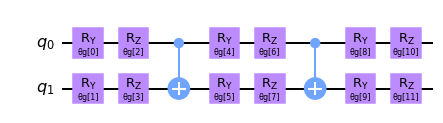

In [10]:
from qiskit.circuit.library import TwoLocal

generator_circuit = TwoLocal(2, ['ry', 'rz'], 'cx', 'full', reps = 2, parameter_prefix = 'θg', name = 'Generator')

generator_circuit.decompose().draw()

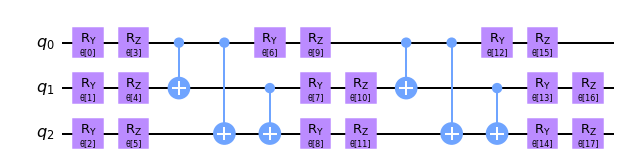

In [11]:
from qiskit.circuit.library import EfficientSU2

discriminator_circuit = EfficientSU2(3, ['ry', 'rz'], 'full', reps = 2)

discriminator_circuit.decompose().draw()

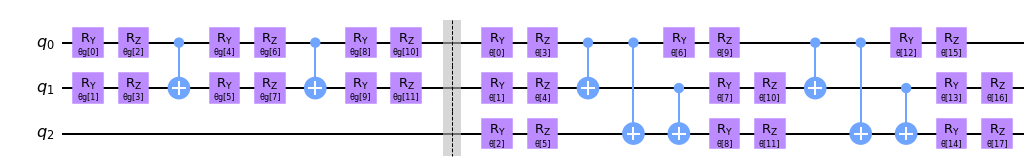

In [12]:
# create the full circuit
gen_disc_circuit = QuantumCircuit(3)

# add individual circuits into the full circuit
gen_disc_circuit.compose(generator_circuit, inplace = True)
gen_disc_circuit.barrier()
gen_disc_circuit.compose(discriminator_circuit, inplace = True)

gen_disc_circuit.decompose().draw()

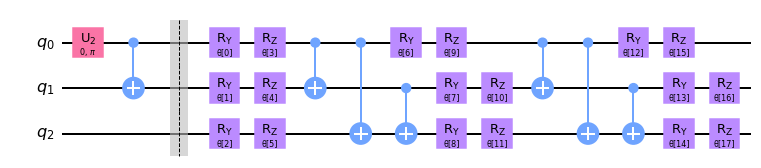

In [13]:
# create the full circuit
real_disc_circuit = QuantumCircuit(3)

# add individual circuits into the full circuit
real_disc_circuit.compose(real_state, inplace = True)
real_disc_circuit.barrier()
real_disc_circuit.compose(discriminator_circuit, inplace = True)

real_disc_circuit.decompose().draw()

* The cost function for the descriminator is the difference between the probabilities of gettting the real state from generator's state minus the one getting the real from real state

$ fd_{cost} = Pr(D(\theta, G(\theta_g)) = \ket{real}) - Pr(D(\theta, R) = \ket{real}) $

* for the generator the cost function will be the negation of the discriminator ommiting the term tith the real state involved

$ fg_{cost} = -Pr(D(\theta, G(\theta_g)) = \ket{real}) $

Choosing the $ \ket{real} = \ket{1} $ we can get the probability getting the real state adding up all probabilities that give 1 in the auxillary qubit

In [14]:
from qiskit.quantum_info import Statevector

def generator_cost(gen_params: tf.Tensor) :
    full_params = np.append(disc_params.numpy(), gen_params.numpy())

    probabilities = Statevector(gen_disc_circuit.bind_parameters(full_params)).probabilities()

    # Get total prob of measuring |1> on q2
    prob_fake_true = np.sum(probabilities[0b100:])
    cost = -prob_fake_true 
    return cost

def discriminator_cost(disc_params: tf.Tensor) :
    full_params = np.append(disc_params.numpy(), gen_params.numpy())

    gen_disc_prob = Statevector(gen_disc_circuit.bind_parameters(full_params)).probabilities()
    real_disc_prob = Statevector(real_disc_circuit.bind_parameters(disc_params.numpy())).probabilities()

    # Get total prob of measuring |1> on q2
    prob_fake_true = np.sum(gen_disc_prob[0b100:])

    # Get total prob of measuring |1> on q2
    prob_real_true = np.sum(real_disc_prob[0b100:])

    cost = prob_fake_true - prob_real_true
    
    return cost

In [15]:
def calculate_KL(model_distribution: dict, target_distribution: dict):
    # Kullback Leibler Divergence

    divergence = 0

    for bitstring, p_data in target_distribution.items():
        if np.isclose(p_data, 0, atol=1e-8):
            continue

        if bitstring in model_distribution.keys():
            divergence += (p_data * np.log(p_data) - p_data * np.log(model_distribution[bitstring]))

        else:
            divergence += p_data * np.log(p_data) - p_data * np.log(1e-6)
    
    return divergence

In [16]:
from qiskit.utils import QuantumInstance
from qiskit import Aer
from qiskit_machine_learning.neural_networks import CircuitQNN

quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

# create sampling neural network with CircuitQNN for generator - discriminator circuit
gen_qnn = CircuitQNN(gen_disc_circuit, gen_disc_circuit.parameters[:discriminator_circuit.num_parameters], gen_disc_circuit.parameters[discriminator_circuit.num_parameters:], sparse = True, quantum_instance = quantum_instance)

# create sampling neural network with CircuitQNN for discriminator fed with generated data, now we train the dicscriminator
disc_gen_qnn = CircuitQNN(gen_disc_circuit, gen_disc_circuit.parameters[discriminator_circuit.num_parameters:], gen_disc_circuit.parameters[:discriminator_circuit.num_parameters], sparse = True, quantum_instance = quantum_instance)

# create sampling neural network with CircuitQNN for discriminator fed with real data, now we train the dicscriminator
disc_real_qnn = CircuitQNN(real_disc_circuit, [], gen_disc_circuit.parameters[:discriminator_circuit.num_parameters], sparse = True, quantum_instance = quantum_instance)

In [17]:
import tensorflow as tf

# Initialize parameters
init_gen_params = np.random.uniform(low = -np.pi, high = np.pi, size = (generator_circuit.num_parameters,))
init_disc_params = np.random.uniform(low = -np.pi, high = np.pi, size = (discriminator_circuit.num_parameters,))

gen_params = tf.Variable(init_gen_params)
disc_params = tf.Variable(init_disc_params)

print(init_disc_params)

[-0.09915448 -0.1446938  -0.55481406 -2.79674503  0.42214832  1.40303132
 -2.06267792 -1.85732378 -3.00902338  1.88996877  1.9113152   1.56313832
  1.87641673  1.86693802  1.07292672  2.99608468  2.95117893  0.94806164]


2022-07-09 22:24:49.120227: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 22:24:49.120430: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-09 22:24:49.120502: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-07-09 22:24:49.120557: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-07-09 22:24:49.120613: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

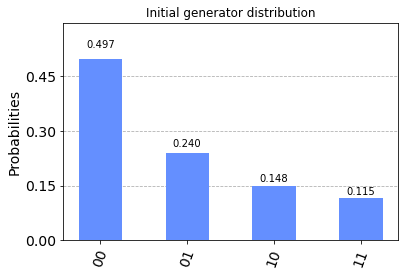

In [18]:
init_gen_circuit = generator_circuit.bind_parameters(init_gen_params)
init_prob_dict = Statevector(init_gen_circuit).probabilities_dict()

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1, 1, sharey=True)
ax1.set_title("Initial generator distribution")
plot_histogram(init_prob_dict, ax=ax1)

In [19]:
# use Adam optimizers from keras
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.02)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.02)

In [20]:
best_gen_params = tf.Variable(init_gen_params)
gloss = []
dloss = []
kl_div = []

In [21]:
import pickle # to serialize and deserialize variables
table_headers = "Epoch / Generator cost / Discriminator cost / KL Div"
print(table_headers)

for epoch in range(100):
    disc_steps = 5 # ratio of discriminator updates / generator updates is 5 : 1

    for disc_step in range(disc_steps):
        # compute partial derivatives
        disc_gen_grads = disc_gen_qnn.backward(gen_params, disc_params)[1].todense()[0, 0b100:]

        disc_gen_grads = np.sum(disc_gen_grads, axis = 0)

        disc_real_grads = disc_real_qnn.backward([], disc_params)[1].todense()[0, 0b100:]

        disc_real_grads = np.sum(disc_real_grads, axis = 0)

        # compute disc cost  
        grad_disc_cost = [disc_gen_grads[i] - disc_real_grads[i] for i in range(discriminator_circuit.num_parameters)]
        grad_disc_cost = tf.convert_to_tensor(grad_disc_cost)

        # update the discriminator parameters  with the optimizer
        discriminator_optimizer.apply_gradients(zip([grad_disc_cost], [disc_params]))

        if disc_step == disc_steps - 1 :
            dloss.append(discriminator_cost(disc_params))

    # after 5 update of discriminator, update the generator parameters now
    # compute partial derivatives
    gen_grads = gen_qnn.backward(disc_params, gen_params)[1].todense()[0, 0b100:]
    
    gen_grads = - np.sum(gen_grads, axis = 0)

    # then update the generator parameters
    generator_optimizer.apply_gradients(zip([gen_grads], [gen_params]))
    gloss.append(generator_cost(gen_params))

    # after updating the parameters of generator and discriminator
    # track the KL divergense and save best parameters

    # Create test circuit with updated gen parameters
    gen_checkpoint_circuit = generator_circuit.bind_parameters(gen_params.numpy())
    # Retrieve probability distribution of current generator
    gen_prob_dict = Statevector(gen_checkpoint_circuit).probabilities_dict()
    # Constant real probability distribution
    real_prob_dict = Statevector(real_state).probabilities_dict()

    current_kl = calculate_KL(gen_prob_dict, real_prob_dict)
    kl_div.append(current_kl)
    if np.min(kl_div) == current_kl: 
        # New best
        # serialize+deserialize to simply ensure zero links
        best_gen_params = pickle.loads(pickle.dumps(gen_params))

    if epoch % 10 == 0:
        # print table for every 10 epochs
        for header, val in zip(table_headers.split('/'),
                            (epoch, gloss[-1], dloss[-1], kl_div[-1])):
            print(f"{val:.3g} ".rjust(len(header)+1), end="")
        print()

Epoch / Generator cost / Discriminator cost / KL Div
     0           -0.529               0.0138   0.747 
    10            -0.33               -0.377   0.874 
    20           -0.241               -0.588   0.423 
    30           -0.386               -0.276  0.0711 
    40           -0.305               -0.137  0.0335 
    50           -0.579              -0.0578  0.0245 
    60           -0.273               -0.267   0.106 
    70           -0.465               -0.178   0.024 
    80           -0.834               0.0945  0.0607 
    90           -0.363               -0.356   0.135 


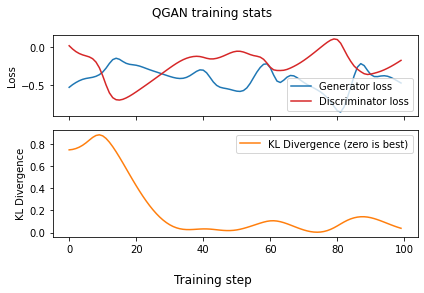

In [22]:
fig, (loss, kl) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [0.75, 1]}, figsize=(6,4))
fig.suptitle('QGAN training stats')
fig.supxlabel('Training step')

loss.plot(range(len(gloss)), gloss, label="Generator loss")
loss.plot(range(len(dloss)), dloss, label="Discriminator loss", color="C3")
loss.legend()
loss.set(ylabel='Loss')

kl.plot(range(len(kl_div)), kl_div, label="KL Divergence (zero is best)", color="C1")
kl.set(ylabel='KL Divergence')
kl.legend()
fig.tight_layout()

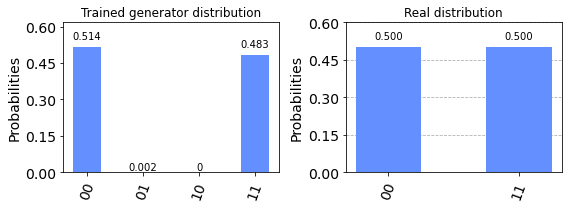

In [23]:
# Create test circuit with new parameters
gen_checkpoint_circuit = generator_circuit.bind_parameters(best_gen_params.numpy())

gen_prob_dict = Statevector(gen_checkpoint_circuit).probabilities_dict()

real_prob_dict = Statevector(real_state).probabilities_dict() # constant

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
plot_histogram(gen_prob_dict, ax = ax1)

ax1.set_title("Trained generator distribution")
plot_histogram(real_prob_dict, ax = ax2)

ax2.set_title("Real distribution")
fig.tight_layout()